In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D,Dropout,MaxPooling2D,Flatten,Dense,BatchNormalization
from tensorflow.keras import regularizers
import keras
import shutil
import os
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf


In [2]:
import tensorflow
print(tensorflow.__version__)


2.9.1


In [3]:
x = []
y = []
datadir = r'Brain Tumor MRI Images 44 Classes'
classes = os.listdir(datadir)
Categories = []
for file_label in os.listdir(datadir):
    Categories.append(file_label)
    for file_name in os.listdir(datadir+'/'+file_label):
        x.append(datadir+'/'+file_label+'/'+file_name)
        y.append(file_label)

dataset=pd.DataFrame({
        'image_path' : x,
        'label' : y
    })

In [4]:
train_df, test_df = train_test_split(dataset, test_size=0.3, shuffle=True, random_state=123, stratify=dataset['label'])
test_df, valid_df = train_test_split(test_df, test_size=0.5, shuffle=True, random_state=123)

In [5]:
print("train_df = ",len(train_df))
print("valid_df = ",len(valid_df))
print("test_df = ",len(test_df))

train_df =  3135
valid_df =  672
test_df =  672


In [6]:
""" #train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,horizontal_flip= True) #zoom_range=0.5,rotation_range=0.5,vertical_flip=True
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,rescale=1./255,rotation_range=20,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,rescale=1./255) """

" #train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,horizontal_flip= True) #zoom_range=0.5,rotation_range=0.5,vertical_flip=True\ntrain_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,rescale=1./255,rotation_range=20,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')\ntest_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,rescale=1./255) "

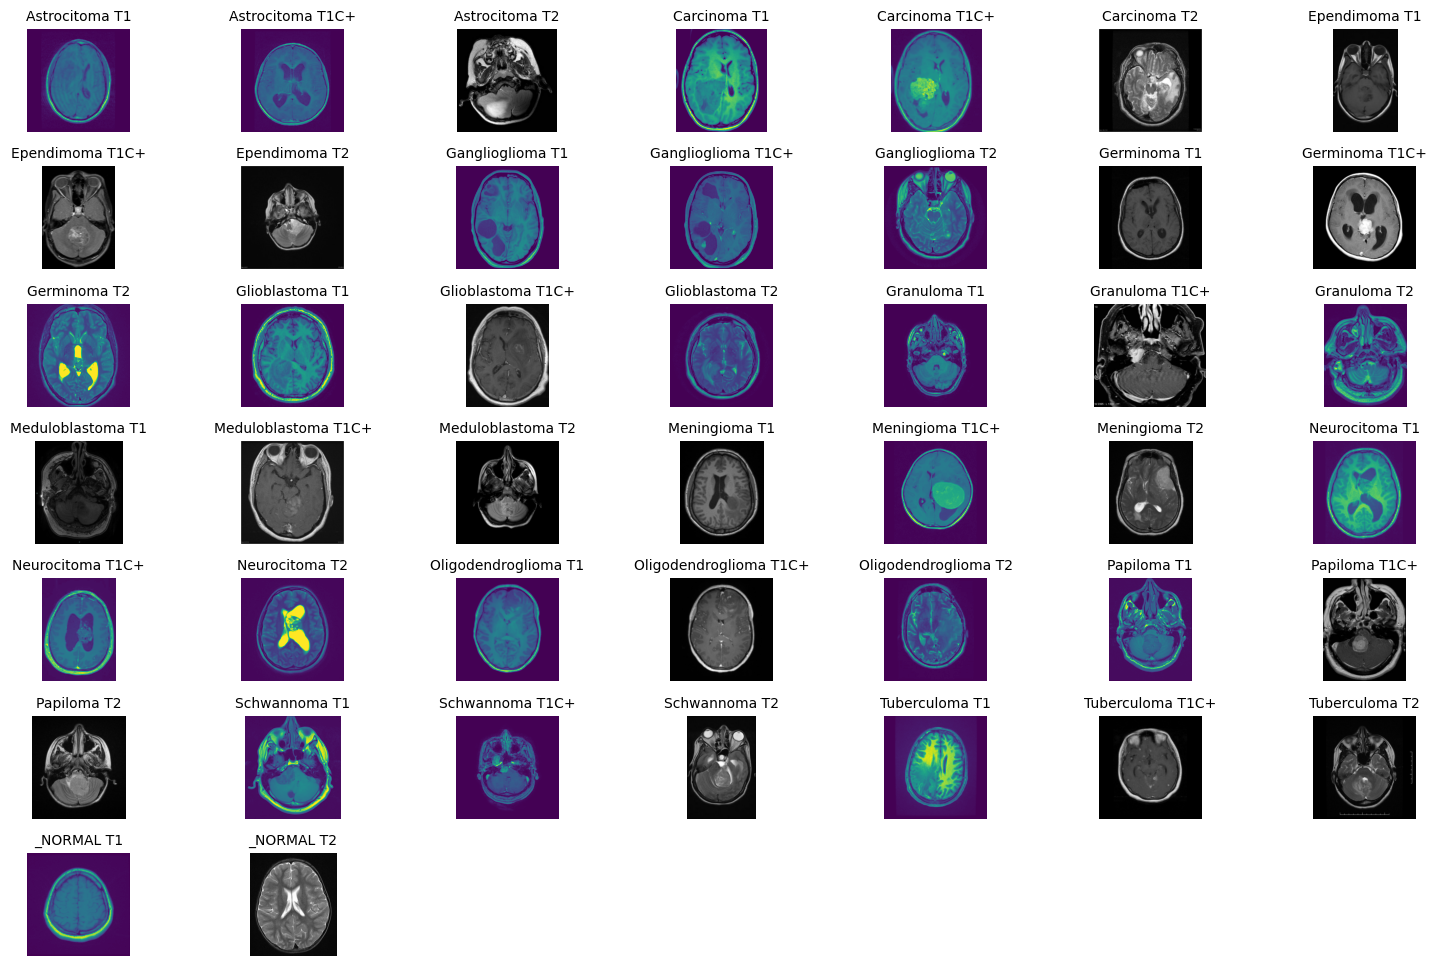

In [7]:
import random
a=0
plt.figure(figsize=(15,10))
for i in classes:
    ax = plt.subplot(7,7, a+1)
    plt.tight_layout()
    path=os.path.join(datadir+'/'+i)
    img = plt.imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(img)
    plt.title(i,fontsize=10)
    plt.axis('off')
    a+=1
plt.savefig('models/44class/sample_44.png',bbox_inches='tight')
plt.show()


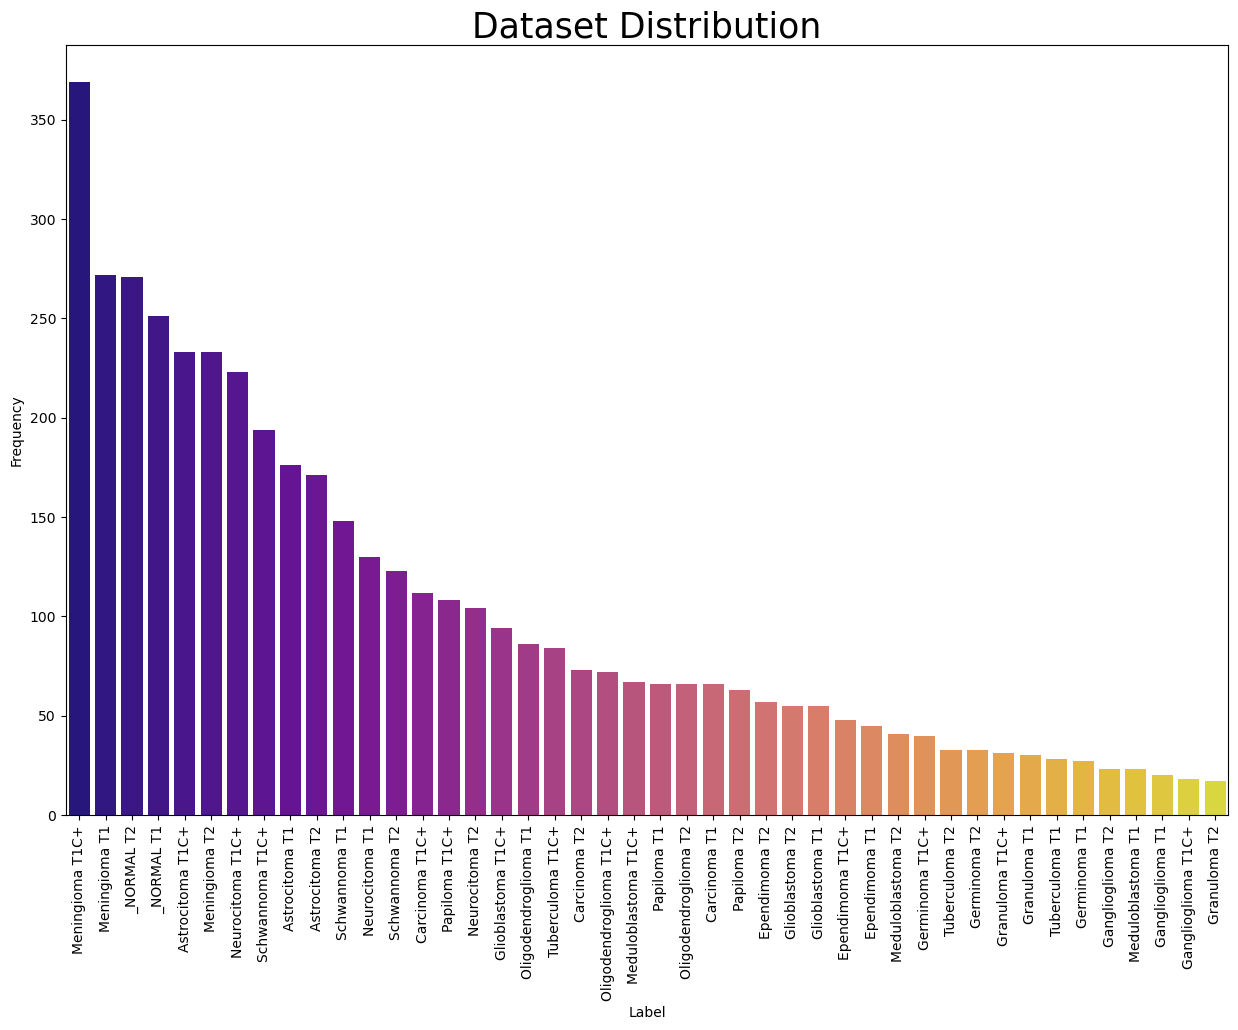

In [8]:
x=dataset.label
plt.figure(figsize=(15,10))
plt.title('Dataset Distribution', fontsize=25)
sns.countplot(x = x, palette='plasma', order = x.value_counts().index)
plt.xticks(rotation = 90, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Label', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.savefig('models/44class/distribution_44.png',bbox_inches='tight')
plt.show()

In [9]:
train_datagen = ImageDataGenerator(horizontal_flip= True)

test_datagen = ImageDataGenerator()

In [10]:
training_set = train_datagen.flow_from_dataframe( train_df, 
                                       x_col= 'image_path', 
                                       y_col= 'label', 
                                       target_size= (224,224), 
                                       class_mode= 'categorical',
                                       color_mode= "rgb", 
                                       shuffle= True, 
                                       batch_size= 15)

Found 3134 validated image filenames belonging to 44 classes.


c:\Users\Ruby\anaconda3\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [11]:
vald_set = test_datagen.flow_from_dataframe( valid_df, 
                                       x_col= 'image_path', 
                                       y_col= 'label', 
                                       target_size= (224,224), 
                                       class_mode= 'categorical',
                                       color_mode= "rgb", 
                                       shuffle= True, 
                                       batch_size= 15)

Found 672 validated image filenames belonging to 44 classes.


In [12]:
test_set = test_datagen.flow_from_dataframe( test_df, 
                                      x_col= 'image_path', 
                                      y_col= 'label', 
                                      target_size= (224,224), 
                                      class_mode= 'categorical',
                                      color_mode= "rgb", 
                                      shuffle= False, 
                                      batch_size= 15)

Found 672 validated image filenames belonging to 44 classes.


In [13]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [13]:
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet",input_shape= (224, 224,3), pooling= 'max')
#base_model = tf.keras.applications.resnet50.ResNet50(include_top=False,pooling='avg',weights='imagenet',input_shape= (224, 224,3))

In [14]:
""" for layer in base_model.layers:
    layer.trainable=False """

' for layer in base_model.layers:\n    layer.trainable=False '

In [18]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(44, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 44)                11308     
                                                                 
Total params: 29,057,571
Trainable params: 28,880,732
Non-trainable params: 176,839
______________________________________

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 44)                11308     
                                                                 
Total params: 29,057,571
Trainable params: 28,880,732
Non-trainable params: 176,839
______________________________________

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5)

checkpoint_name = 'Weights-{epoch:03d}-val_accuracy-{val_accuracy:.5f}.h5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_accuracy', verbose = 1, save_best_only = True,save_weights_only=True, mode ='auto')

checkpoint_name1 = 'Weights-{epoch:03d}-val_loss-{val_loss:.5f}.h5' 
checkpoint1 = ModelCheckpoint(checkpoint_name1, monitor='val_loss', verbose = 1, save_best_only = True,save_weights_only=True, mode ='auto')

In [ ]:
res = model.fit(training_set,validation_data = vald_set, epochs=100,shuffle=False,callbacks=[checkpoint,checkpoint1,early_stopping])

In [14]:
#model.load_weights('models/1/Weights-023-val_accuracy-0.96429.h5')
model = keras.models.load_model('44class_96.5.h5')

In [15]:
train_score = model.evaluate(training_set)
valid_score = model.evaluate(vald_set)
test_score = model.evaluate(test_set)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

45/45 [==============================] - 6s 123ms/step - loss: 0.4862 - accuracy: 0.9658
Train Loss:  0.32383614778518677
Train Accuracy:  0.9993618130683899
--------------------
Validation Loss:  0.49405741691589355
Validation Accuracy:  0.9642857313156128
--------------------
Test Loss:  0.48619741201400757
Test Accuracy:  0.9657738208770752


In [26]:
#model.save('44class_96.5.h5')
#tf.saved_model.save(model, '/models')

(-0.5, 223.5, 223.5, -0.5)

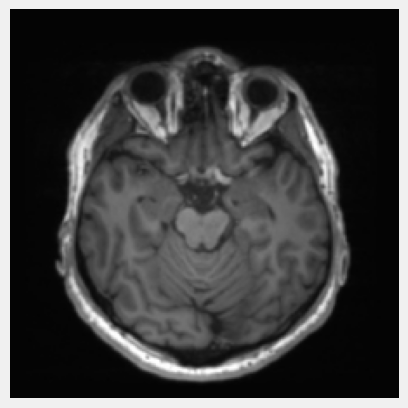

In [35]:
img = tf.keras.utils.load_img(
    "Brain Tumor MRI Images 44 Classes/_NORMAL T1/0a0bc6879f5d5d14c4df229b64b801_big_gallery.jpeg",
    grayscale=False,
    color_mode='rgb',
    target_size=(224,224),
    interpolation='nearest',
    keep_aspect_ratio=False
    )
plt.imshow(img)
plt.axis('off')


In [36]:
img = np.array(img).reshape(-1, 224, 224, 3)
img.shape

(1, 224, 224, 3)

In [37]:
y_pred = model.predict(img)
y_pred_labels = np.argmax(y_pred, axis=1)

1/1 [==============================] - 4s 4s/step


In [38]:
#class_names = list(test_set.class_indices.keys())

In [39]:
result=['Astrocitoma T1',
 'Astrocitoma T1C+',
 'Astrocitoma T2',
 'Carcinoma T1',
 'Carcinoma T1C+',
 'Carcinoma T2',
 'Ependimoma T1',
 'Ependimoma T1C+',
 'Ependimoma T2',
 'Ganglioglioma T1',
 'Ganglioglioma T1C+',
 'Ganglioglioma T2',
 'Germinoma T1',
 'Germinoma T1C+',
 'Germinoma T2',
 'Glioblastoma T1',
 'Glioblastoma T1C+',
 'Glioblastoma T2',
 'Granuloma T1',
 'Granuloma T1C+',
 'Granuloma T2',
 'Meduloblastoma T1',
 'Meduloblastoma T1C+',
 'Meduloblastoma T2',
 'Meningioma T1',
 'Meningioma T1C+',
 'Meningioma T2',
 'Neurocitoma T1',
 'Neurocitoma T1C+',
 'Neurocitoma T2',
 'Oligodendroglioma T1',
 'Oligodendroglioma T1C+',
 'Oligodendroglioma T2',
 'Papiloma T1',
 'Papiloma T1C+',
 'Papiloma T2',
 'Schwannoma T1',
 'Schwannoma T1C+',
 'Schwannoma T2',
 'Tuberculoma T1',
 'Tuberculoma T1C+',
 'Tuberculoma T2',
 '_NORMAL T1',
 '_NORMAL T2']

In [40]:
result[y_pred_labels[0]]

'_NORMAL T1'

In [16]:
y_pred = model.predict(test_set)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = test_set.classes

45/45 [==============================] - 8s 121ms/step


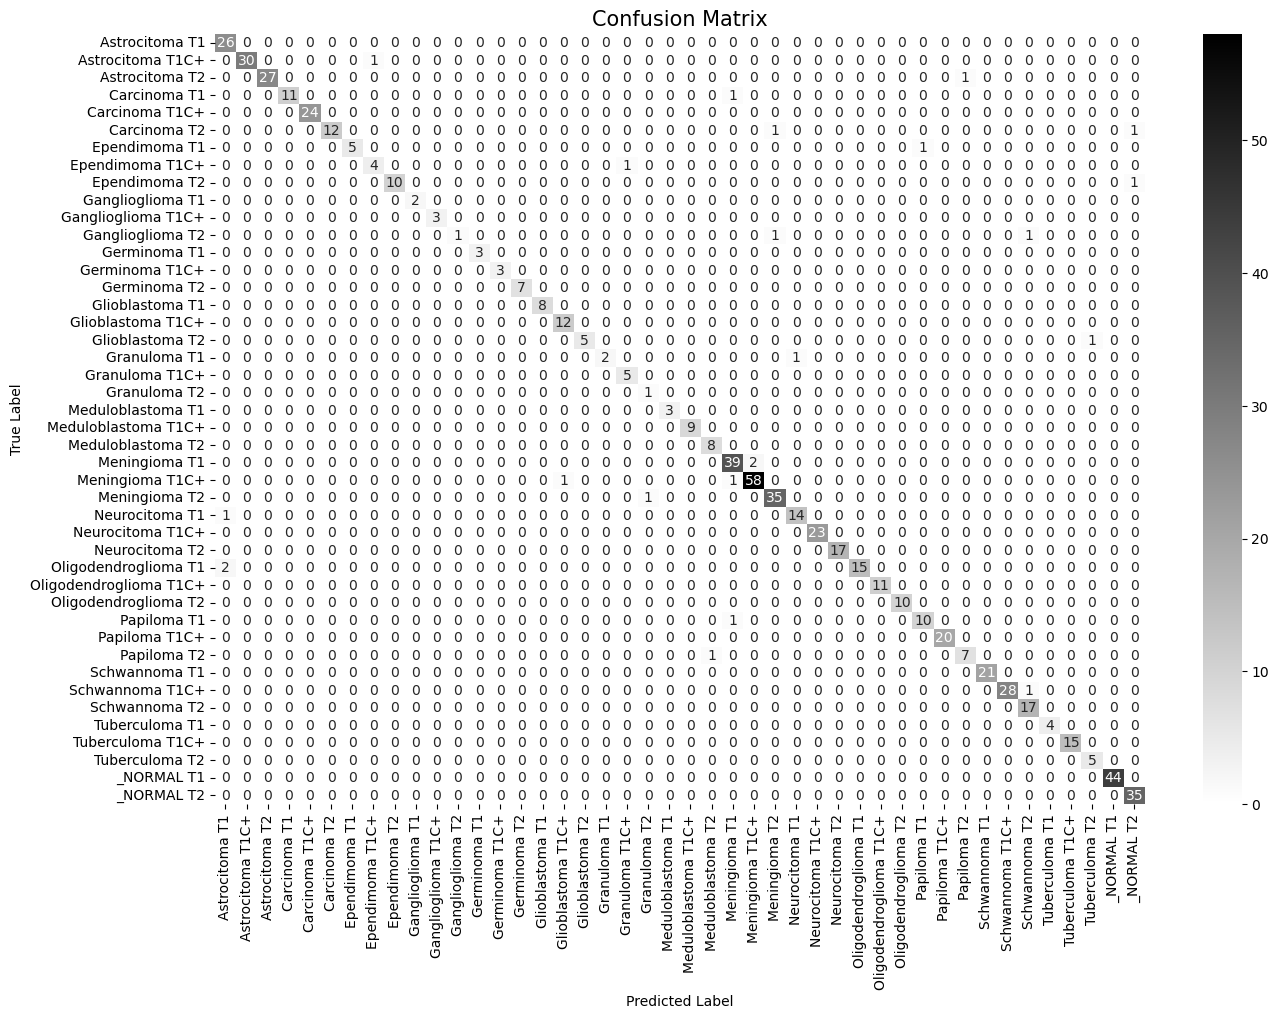

In [17]:
class_names = list(test_set.class_indices.keys())
confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(15,10))
sns.heatmap(confusion_mtx, annot=True, xticklabels=class_names, yticklabels=class_names,cmap='binary')
plt.title("Confusion Matrix",fontsize=15)
plt.xlabel("Predicted Label",fontsize=10)
plt.ylabel("True Label",fontsize=10)
plt.savefig('models/44class/confusion_matrix_44.png',bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(res.history['loss'], 'r', label= 'Training loss')
plt.plot(res.history['val_loss'], 'b', label= 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(res.history['accuracy'], 'r', label= 'Training Accuracy')
plt.plot(res.history['val_accuracy'], 'b', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.savefig('EfficientNetB5_V3.png')
plt.show()

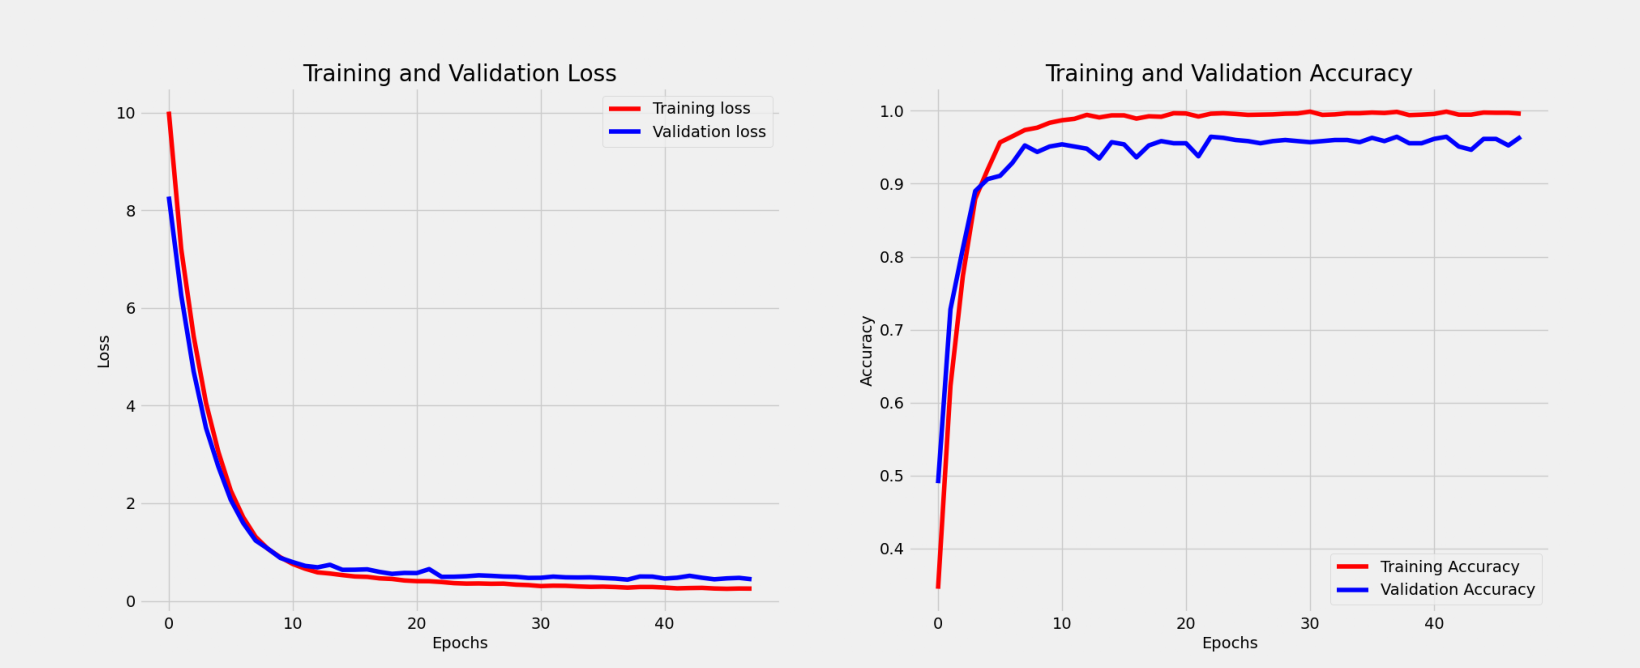

In [63]:
plt.figure(figsize= (20, 8))
plt.imshow(plt.imread('models/44class/EfficientNetB5_44_classes.png'))
plt.axis('off')
plt.show()